# Overlapping data transfer and computations with the Mandelbrot set

to run, use the python environment from the HPC4WC course

In [1]:
import time
import numpy as np
import cupy as cp
import cupyx as cpx
import matplotlib.pyplot as plt

### Mandelbrot set with Array Approach
Adapted from [Wikipedia](https://de.wikipedia.org/wiki/Mandelbrot-Menge#Komplexe_Matrizen_und_Potentialfunktionen) (german)

In [2]:
def mandel_array(C_cpu, r=10**3, max_iter=10**3):
    # create temporary gpu arrays
    C = cp.asarray(C_cpu)
    T = cp.zeros(C.shape, dtype=cp.int64)
    Z = cp.zeros_like(C)
    
    # perform iterations
    for k in range(np.int64(max_iter)):
        M = abs(Z) < r
        T[M] = T[M] + 1
        Z[M] = Z[M] ** 2 + C[M]
        
    return T.get()


In [3]:
# create initial data
nx, ny = 2**10, 2**10
xrange = (-1.4, -1.35)
yrange = (0., 0.05)

x = np.linspace(*xrange, nx)
y = np.linspace(*yrange, ny)

X, Y = np.meshgrid(x, y)
C = (X + Y * 1j)

In [4]:
T = mandel_array(C, 1e3, 10**3)

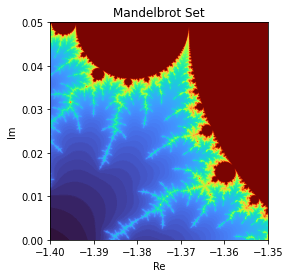

In [5]:
plt.imshow(np.log10(T), extent=[*xrange, *yrange], cmap="turbo")
plt.title("Mandelbrot Set")
plt.xlabel("Re")
plt.ylabel("Im")
plt.show()

### Runtime Measurement

In [6]:
niter = 20
nwarm = 5

In [7]:
tic = 0.
for it in range(niter):
    if it == nwarm:
        tic = time.perf_counter()
        
    T = mandel_array(C)
    
toc = time.perf_counter()

print("time per call:", (toc - tic) / (niter - nwarm), "sec")

time per call: 0.9972771221461395 sec


### Profiling
performed by copying the above code to a separate script:
```
==27959== NVPROF is profiling process 27959, command: python mandel.py
==27959== Profiling application: python mandel.py
==27959== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   34.49%  2.04515s    150000  13.634us  2.0480us  40.863us  cupy_scan_naive
                   16.67%  988.14ms     30000  32.937us  22.592us  105.98us  cupy_getitem_mask
                   11.97%  709.96ms    100000  7.0990us  1.7910us  14.528us  cupy_bsum_shfl
                   10.20%  604.84ms     20000  30.242us  22.752us  97.215us  cupy_scatter_update_mask
                    7.91%  469.01ms     10000  46.901us  46.048us  48.479us  cupy_absolute__complex128_float64
                    6.95%  412.29ms     10000  41.229us  34.496us  174.75us  cupy_power__complex128_complex_complex128
                    5.54%  328.35ms     10000  32.834us  31.584us  92.480us  cupy_add__complex128_complex128_complex128
                    3.73%  221.39ms     10000  22.138us  21.664us  22.912us  cupy_less__float64_float_bool
                    1.61%  95.506ms     10000  9.5500us  8.5120us  33.119us  cupy_add__int64_int_int64
                    0.89%  52.909ms     50001  1.0580us     959ns  3.2504ms  [CUDA memcpy DtoH]
                    0.02%  1.3463ms         1  1.3463ms  1.3463ms  1.3463ms  [CUDA memcpy HtoD]
                    0.00%  47.520us         2  23.760us  17.408us  30.112us  [CUDA memset]
```

## Kernel Approach

In [8]:
mandel_kernel = cp.ElementwiseKernel("float64 x, float64 y, float64 r, int64 nit",  # input params
                                     "int64 t",  # output params
                                     """
                                         double re = x;
                                         double im = y;
                                         double re2 = re*re;
                                         double im2 = im*im;
                                         double r2  = r*r;
                                         t = 0;
                                         while (t < nit && re2 + im2 < r2) {
                                             re = re2 - im2 + x;
                                             im = 2*re*im + y;
                                             re2 = re*re;
                                             im2 = im*im;
                                             t  = t + 1;
                                         }
                                     """,
                                     "mandel_kernel")
                                     

In [9]:
X_gpu = cp.asarray(X)
Y_gpu = cp.asarray(Y)
T_gpu = mandel_kernel(X_gpu, Y_gpu, 1e3, 10**3)
T = T_gpu.get()


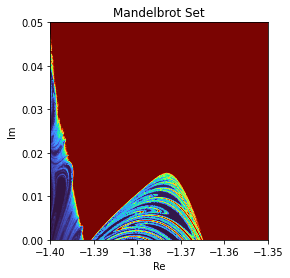

In [10]:
plt.imshow(T, extent=[*xrange, *yrange], cmap="turbo")
plt.title("Mandelbrot Set")
plt.xlabel("Re")
plt.ylabel("Im")
plt.show()

Apparently, something does not work as expected in this approach. We continue with the array approach, which is a bit slower, but provides the expected result. 

## Decomposition of Work

1. decompose work
2. asynchronously paste parts
3. check when all have finished

### Overlapping with different streams

create a separate stream using `cp.cuda.Stream()`

use asynchronous get by specifying a pinned memory as output array `get(out=A_cpu, blocking=False)`

where `A_cpu` is initialised using the `cupyx.***_pinned` functions (available are `empty, empty_like, zeros, zeros_like`)

check if all are finished using `cp.cuda.Device().synchronize()`. Alternatively, can also busy-loop on `stream.done` or iteratively `stream.synchronize()` for all streams.



In [11]:
def mandel_async(C_in, T_out, r=10**3, max_iter=10**3):
    # create temporary gpu arrays
    C = cp.asarray(C_in)
    T = cp.zeros(C.shape, dtype=cp.int64)
    Z = cp.zeros_like(C)
    
    # perform iterations
    for k in range(np.int64(max_iter)):
        M = abs(Z) < r
        T[M] = T[M] + 1
        Z[M] = Z[M] ** 2 + C[M]
        
    return T.get(out=T_out)

In [12]:
# simple version with two streams

s1 = cp.cuda.Stream()
s2 = cp.cuda.Stream()

T_out = cpx.zeros_pinned(C.shape, dtype=np.int64)

half = nx // 2
with s1:
    mandel_async(C[:half, :], T_out[:half, :])
with s2:
    mandel_async(C[half:, :], T_out[half:, :])
    
s1.synchronize()
s2.synchronize()
    

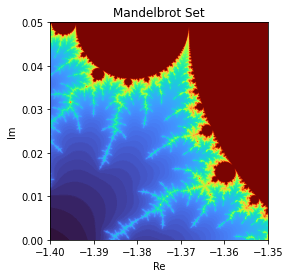

In [13]:
plt.imshow(np.log10(T_out), extent=[*xrange, *yrange], cmap="turbo")
plt.title("Mandelbrot Set")
plt.xlabel("Re")
plt.ylabel("Im")
plt.show()

In [14]:
def mandel_streams(C_in, nstream=2, r=10**3, max_iter=10**3):
    T_out = cpx.zeros_pinned(C_in.shape, dtype=np.int64)
    streams = [cp.cuda.Stream() for _ in range(nstream)]
    bdry_x = [i*C_in.shape[0] // nstream for i in range(nstream)]
    bdry_x.append(C_in.shape[0])
    for i, s in enumerate(streams):
        with s:
            mandel_async(C_in[bdry_x[i]:bdry_x[i+1], :], T_out[bdry_x[i]:bdry_x[i+1], :])
            
    for s in streams:
        s.synchronize()
        
    return T_out

In [15]:
T_s = mandel_streams(C, nstream=4)

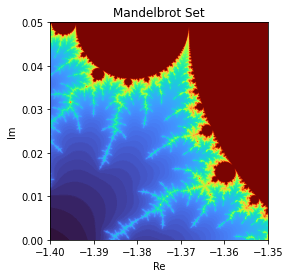

In [16]:
plt.imshow(np.log10(T_s), extent=[*xrange, *yrange], cmap="turbo")
plt.title("Mandelbrot Set")
plt.xlabel("Re")
plt.ylabel("Im")
plt.show()

In [17]:
for nstream in [1, 2, 4, 8]:
    tic = 0.
    for it in range(niter):
        if it == nwarm:
            tic = time.perf_counter()

        Ts = mandel_streams(C, nstream=nstream)

    toc = time.perf_counter()

    print("time using", nstream, "streams:", (toc - tic) / (niter - nwarm), "sec")

time using 1 streams: 1.0239402394741774 sec
time using 2 streams: 1.9132647400721907 sec
time using 4 streams: 3.332297530397773 sec
time using 8 streams: 6.603373595451315 sec


As one can see, the total time increases with the number of streams used, even tough the total work remains constant.

### Profiling of multiple Streams

```
==29382== NVPROF is profiling process 29382, command: python mandel.py stream
==29382== Profiling application: python mandel.py stream
==29382== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   35.33%  285.99ms     40000  7.1490us  2.4000us  12.288us  cupy_scan_naive
                   14.93%  120.89ms     12000  10.074us  5.5350us  25.856us  cupy_getitem_mask
                   11.98%  97.003ms      4000  24.250us  4.3200us  98.240us  cupy_power__complex128_complex_complex128
                   11.61%  93.947ms     20000  4.6970us  4.4790us  8.6080us  cupy_bsum_shfl
                    8.69%  70.373ms      8000  8.7960us  5.5040us  23.904us  cupy_scatter_update_mask
                    5.68%  45.974ms      4000  11.493us  9.7600us  13.248us  cupy_absolute__complex128_float64
                    4.28%  34.657ms      4000  8.6640us  1.8880us  24.992us  cupy_add__complex128_complex128_complex128
                    3.02%  24.440ms      4000  6.1090us  5.5680us  7.6800us  cupy_less__float64_float_bool
                    2.68%  21.681ms     20004  1.0830us  1.0230us  167.39us  [CUDA memcpy DtoH]
                    1.62%  13.121ms      4000  3.2800us  1.5680us  7.6800us  cupy_add__int64_int_int64
                    0.17%  1.3514ms         4  337.84us  337.63us  338.27us  [CUDA memcpy HtoD]
                    0.01%  57.152us         8  7.1440us  4.8320us  9.2160us  [CUDA memset]
      API calls:   52.73%  770.29ms    100000  7.7020us  4.7670us  430.96us  cuLaunchKernel
                   21.75%  317.72ms     20008  15.879us  8.4860us  407.67us  cudaMemcpyAsync
                   18.91%  276.21ms    636146     434ns     283ns  420.85us  cudaGetDevice
                    2.69%  39.307ms         8  4.9134ms  13.008us  39.200ms  cudaMemsetAsync
                    1.87%  27.367ms     40010     684ns     377ns  383.49us  cudaSetDevice
                    1.43%  20.838ms        12  1.7365ms  830.49us  7.1028ms  cuModuleLoadData
                    0.38%  5.5277ms        36  153.55us  9.1610us  332.11us  cudaMalloc
                    0.23%  3.3603ms         2  1.6801ms  1.1292ms  2.2311ms  cudaHostAlloc
                    0.01%  134.25us         4  33.561us  1.4870us  122.14us  cudaStreamSynchronize
                    0.00%  55.075us         1  55.075us  55.075us  55.075us  cudaMemGetInfo
                    0.00%  27.348us         7  3.9060us  1.9130us  10.174us  cudaEventQuery
                    0.00%  27.089us         4  6.7720us  1.9750us  20.301us  cudaStreamCreate
                    0.00%  25.295us         4  6.3230us  3.2080us  15.184us  cudaStreamDestroy
                    0.00%  17.809us         4  4.4520us  2.9640us  7.8390us  cudaEventRecord
                    0.00%  13.665us         4  3.4160us  1.8270us  7.7200us  cudaEventCreateWithFlags
                    0.00%  10.780us         3  3.5930us  2.4610us  5.7370us  cudaEventDestroy
                    0.00%  10.635us        12     886ns     780ns  1.3400us  cuModuleGetFunction
                    0.00%  2.0930us         1  2.0930us  2.0930us  2.0930us  cuDeviceGetCount
                    0.00%  1.7490us         2     874ns     363ns  1.3860us  cudaDeviceGetAttribute
                    0.00%  1.7040us         3     568ns     155ns  1.2780us  cudaGetDeviceCount
                    0.00%     840ns         1     840ns     840ns     840ns  cudaRuntimeGetVersion
```

Comparing this profiling to the one above, we see that a lot more calls to the different functions are performed. This makes sense as now each stream does the same operations. Consequently, since the number of elements processed per call is smaller, the average time per call is reduced. 